📊 Evaluation Metrics for Multiple Linear Regression Model (70/30 Split):

R²: 0.9357 → The model explains 93.57% of the variance in bat risk-taking behaviour.
Adjusted R²: 0.9334 → Adjusted for number of predictors, confirming model reliability.
MAE: 0.0514 → On average, predictions are off by 0.0514 units (scale: 0 to 1).
MSE: 0.0160 → Mean squared error, lower values indicate fewer large errors.
RMSE: 0.1265 → Root mean squared error, interpretable in original units (risk scale).


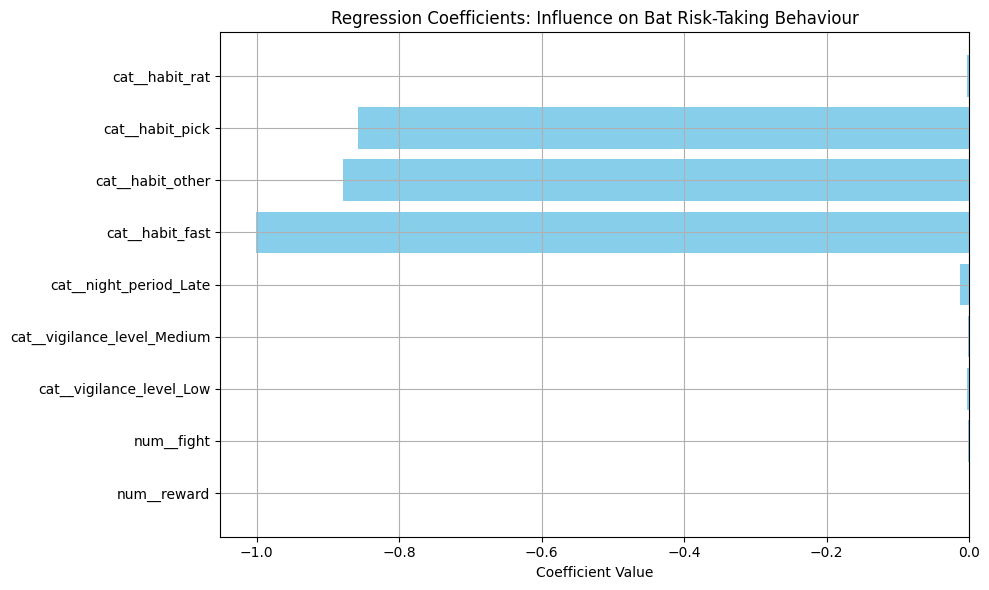

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv("Dataset1_clean.csv")

# Drop rows with missing values in relevant columns
df = df.dropna(subset=['seconds_after_rat_arrival', 'hours_after_sunset', 'reward', 'fight', 'habit'])

# Feature engineering
def categorize_vigilance(seconds):
    if seconds < 150:
        return 'Low'
    elif seconds < 300:
        return 'Medium'
    else:
        return 'High'
df['vigilance_level'] = df['seconds_after_rat_arrival'].apply(categorize_vigilance)
df['night_period'] = df['hours_after_sunset'].apply(lambda x: 'Early' if x < 6 else 'Late')

# Define features and target
X = df[['vigilance_level', 'night_period', 'reward', 'fight', 'habit']]
y = df['risk']

# Define preprocessing for numerical and categorical features
categorical_features = ['vigilance_level', 'night_period', 'habit']
numerical_features = ['reward', 'fight']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('power', PowerTransformer(method='yeo-johnson'))
    ]), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Create pipeline with preprocessing and regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
r2 = pipeline.score(X_test, y_test)
n = len(y_test)
p = pipeline.named_steps['preprocessor'].transform(X_test).shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics with explanation
print("📊 Evaluation Metrics for Multiple Linear Regression Model (70/30 Split):\n")
print(f"R²: {r2:.4f} → The model explains {r2*100:.2f}% of the variance in bat risk-taking behaviour.")
print(f"Adjusted R²: {adjusted_r2:.4f} → Adjusted for number of predictors, confirming model reliability.")
print(f"MAE: {mae:.4f} → On average, predictions are off by {mae:.4f} units (scale: 0 to 1).")
print(f"MSE: {mse:.4f} → Mean squared error, lower values indicate fewer large errors.")
print(f"RMSE: {rmse:.4f} → Root mean squared error, interpretable in original units (risk scale).")

# Extract feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].transform(X_train).shape[1]
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = pipeline.named_steps['regressor'].coef_

# Plot regression coefficients
plt.figure(figsize=(10, 6))
plt.barh(encoded_feature_names, coefficients, color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Regression Coefficients: Influence on Bat Risk-Taking Behaviour")
plt.grid(True)
plt.tight_layout()
plt.savefig("mlr_coefficients_plot.png")
plt.show()